In [8]:
# required libraries
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
# ignore warnings
warnings.filterwarnings("ignore")

# For multiple line outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Lab 3 - Clustering
### Group_4 - Yang Zhang, Reannan McDaniel, Jonathon Roach, Fred Poon
### 8/1/2020
### MSDS_7331

# Table of contents
1. [Business Understanding](#business-understanding) <!-- 10 pts Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs? -->
2. [Data Understanding 1](#data-understanding-1) <!-- 10 pts Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems? -->
3. [Data Understanding 2](#data-understanding-2) <!-- 10 pts Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs. -->
4. [Models and Evaluations](#model-evaluation)
    1. [Model and Evaluation 1 - train and parameters](#model-evaluation-1) <!-- 10 pts Train and adjust parameters -->   
    2. [Model and Evaluation 2 - evaluate and compare](#model-evaluation-2) <!-- 10 pts Evaluate and Compare -->    
    3. [Model and Evaluation 3 - visualize](#model-evaluation-3) <!-- 10 pts Visualize Results -->    
    4. [Model and Evaluation 4 - summarize](#model-evaluation-4) <!-- 20 pts Summarize the Ramifications -->    
5. [Deployment](#deployment) <!-- 10 pts Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? -->
6. [Exceptional Work](#exceptional-work) <!-- 10 pts You have free reign to provide additional analyses or combine analyses. -->

## Business Understanding <a name="business-understanding"></a>
For this analysis, our group will be working with North Carolina Public Schools Report Card and Statistical Profiles Data sets from the years 2014 to 2017. These data sets encompass information across 4 continuous years of educational attributes in North Carolina, USA.  The data is collected from the State of North Carolina at [https://www.dpi.nc.gov/](https://www.dpi.nc.gov/) and made available from the Belk Endowment Educational Attainment Data Repository for North Carolina Public Schools by Dr. Jake Drew. Among other reasons, the data was collected for evaluation of public-school performance for the purpose of efficiently allocating funds to various educational initiatives. Analyses of such data are important because high-impact educational initiatives that are well-funded contribute to increased graduation rates, increased achievement at the post-secondary level, less crime, and greater economic engagement among young people. For the purpose of this exercise, our focus is on predicting graduation rates using various school characteristics, such as type of school (elementary, middle, high, or some combination of the three), social demographics, economic demographics, and location between 2014 and 2017. The Belk Foundation's website says, "Our goal is to empower today’s workforce by creating pathways to and through postsecondary education for underrepresented students".

For the sake of this analysis, we assume that better performing schools have better outcomes in postsecondary education. With North Carolina's rapidly changing demographics, it is important to take into consideration schools' unique needs when allocating funds to strategic investment initiatives. Here, we explore where funding can be best applied based on educational achievement data.

We will explore through visual and mathematical modeling which features best predict the graduation rate. The analysis will come in a combination of classification models to predict. In this analysis we will observe:

- What classification model provides the higher accuracy score?
- What regression model provides a better MAE score?

## Data Understanding - knowing the data <a name="data-understanding-1"></a>

In [2]:
# read in CSV
df2014 = pd.read_csv('https://raw.githubusercontent.com/fredpoon/ds_7331_jyrf_eda/master/Data_Prep/PublicSchools2014_MLnew.csv')
df2015 = pd.read_csv('https://raw.githubusercontent.com/fredpoon/ds_7331_jyrf_eda/master/Data_Prep/PublicSchools2015_MLnew.csv')
df2016 = pd.read_csv('https://raw.githubusercontent.com/fredpoon/ds_7331_jyrf_eda/master/Data_Prep/PublicSchools2016_MLnew.csv')
df2017 = pd.read_csv('https://raw.githubusercontent.com/fredpoon/ds_7331_jyrf_eda/master/Data_Prep/PublicSchools2017_MLnew.csv')

df2014.shape
df2015.shape
df2016.shape
df2017.shape

df2014['Year'] = 2014
df2015['Year'] = 2015 
df2016['Year'] = 2016 
df2017['Year'] = 2017

frames = [df2014, df2015, df2016, df2017]
df_comb_test = pd.concat(frames,join='inner', ignore_index=True)

df_comb_test.info()

(2426, 318)

(2432, 335)

(2430, 328)

(2443, 328)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Columns: 259 entries, vphone_ad to Year
dtypes: float64(237), int64(2), object(20)
memory usage: 19.2+ MB


In [3]:
schoolData = df_comb_test

#Locate the categorical variables in dataset
sD_nominal = schoolData.loc[:, (schoolData.dtypes == object)]
uniqueThreshold = 25

#Delete categorical columns with > 25 unique values (Each unique value becomes a column during one-hot encoding)
oneHotUniqueValueCounts = schoolData[sD_nominal.columns].apply(lambda x: x.nunique())
oneHotUniqueValueCols = oneHotUniqueValueCounts[oneHotUniqueValueCounts >= uniqueThreshold].index
schoolData.drop(oneHotUniqueValueCols, axis=1, inplace=True) 

#Review dataset contents one hot high unique value drops
print('*********After: Removing columns with >= uniqueThreshold unique values***********')
schoolData.info(verbose=False)
print ('\r\nColumns Deleted: ', len(oneHotUniqueValueCols))

*********After: Removing columns with >= uniqueThreshold unique values***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Columns: 250 entries, szip_ad to Year
dtypes: float64(237), int64(2), object(11)
memory usage: 18.6+ MB

Columns Deleted:  9


In [4]:
#Keep an original copy of the Data
schoolData_org = schoolData

#Pop out the SPG information from the Data
schoolData_SPG = schoolData.pop('SPG Grade')
schoolData_SPGScore = schoolData.pop('SPG Score')

# Remove All the Columns that directly used to calculate SPG Grade and Score
schoolData.drop(schoolData.iloc[:, 21:162], inplace=True, axis=1)
schoolData.info(verbose=True)

#Isolate remaining categorical variables
begColumnCt = len(schoolData.columns)

#one hot encode categorical variables
schoolData = pd.get_dummies(data=schoolData,drop_first=True)

#Determine change in column count
endColumnCt = len(schoolData.columns)
columnsAdded = endColumnCt - begColumnCt

#Review dataset contents one hot high unique value drops
print('Columns To One-Hot Encode: ', len(sD_nominal.columns))
print('\r\n*********After: Adding New Columns Via One-Hot Encoding*************************')
schoolData.info(verbose=False)
print ('\r\nNew Columns Created Via One-Hot Encoding: ', columnsAdded)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Data columns (total 107 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   szip_ad                              float64
 1   category_cd                          object 
 2   calendar_type_txt                    object 
 3   sna_pgm_type_cd                      object 
 4   school_type_txt                      object 
 5   calendar_only_txt                    object 
 6   title1_type_cd                       object 
 7   esea_status                          object 
 8   student_num                          float64
 9   lea_avg_student_num                  float64
 10  st_avg_student_num                   float64
 11  Grad_project_status                  object 
 12  Math I_Size                          float64
 13  lea_total_expense_num                float64
 14  lea_salary_expense_pct               float64
 15  lea_services_expense_pct             

In [5]:
#Pick and Choose variables
schoolData_pick = schoolData[[
'TotalTargets_pTarget_PctMet',
'MinorityMalePct',
'MinorityFemalePct',
'short_susp_per_c_num',
'avg_daily_attend_pct',
'title1_type_cd_Y',
'BlackMalePct',
'AsianFemalePct',
'BlackFemalePct',
'HispanicMalePct',
'MathGr3-8_pTarget_PctMet',
'AsianMalePct',
'SciGr5&8_pTarget_PctMet',
'nbpts_num',
'lea_sat_avg_score_num',
'stud_internet_comp_num',
'st_avg_student_num',
'HispanicFemalePct',
'Accomplished_TCHR_Standard 4_Pct',
'Accomplished_TCHR_Standard 3_Pct',
'Developing_TCHR_Standard 2_Pct',
'Accomplished_TCHR_Standard 5_Pct',
'10+ Years_LEA_Exp_Pct_Prin',
'4-10 Years_LEA_Exp_Pct_Prin',
'Accomplished_TCHR_Standard 1_Pct',
'Accomplished_TCHR_Standard 2_Pct',
'Developing_TCHR_Standard 1_Pct',
'pct_GCE_ALL',
'0-3 Years_LEA_Exp_Pct_Prin',
'st_emer_prov_teach_pct',
'lea_sat_participation_pct',
'lea_ap_participation_pct',
'lea_federal_perpupil_num',
'lea_local_perpupil_num',
'advance_dgr_pct',
'Developing_TCHR_Standard 5_Pct',
'lateral_teach_pct',
'lea_flicensed_teach_pct',
'Developing_TCHR_Standard 3_Pct',
'lea_tchyrs_0thru3_pct',
'lea_tchyrs_11plus_pct',
'lea_nbpts_num',
'lea_advance_dgr_pct',
'lea_1yr_tchr_trnovr_pct',
'lea_emer_prov_teach_pct',
'st_flicensed_teach_pct',
'st_tchyrs_0thru3_pct',
'st_1yr_tchr_trnovr_pct',
'lea_tchyrs_4thru10_pct',
'Category_Cd_T',
]]

# Dataset Dimension with picked variables
schoolData_pick.shape

(9731, 50)

,0
count,9216
unique,5
top,C
freq,3973


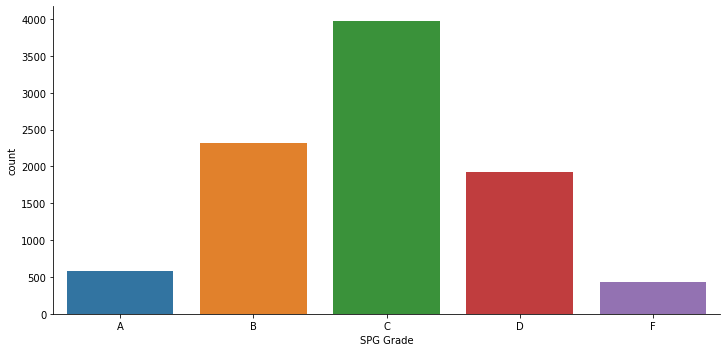

In [10]:
schoolData_SPG_org = schoolData_SPG
#schoolData_SPG = schoolData_SPG_org

import numpy as np
schoolData_SPG= np.select(
    [
        schoolData_SPG == 'A', 
        schoolData_SPG == 'B',
        schoolData_SPG == 'C',
        schoolData_SPG == 'D',
        schoolData_SPG == 'F',
        schoolData_SPG == 'A+NG',
        schoolData_SPG == 'I'
    ], 
    [
        'A', 
        'B',
        'C',
        'D',
        'F',
        'A',
        'NA'
    ],
    default='NA'
)

#Filter out the sample with "NA" on SPG Grade
schoolData_SPG_new = schoolData_SPG[schoolData_SPG!='NA']
schoolData_pick_new = schoolData_pick[schoolData_SPG!='NA']

# Check if the levels of SPG Grade has been altered
s = pd.DataFrame(schoolData_SPG_new)
s.describe()

#Factor Plot for SPG Grade
s.columns=['SPG Grade']

sns.factorplot("SPG Grade", data=s, aspect=2,
                       kind="count", order=['A','B','C','D','F'])

plt.show()

In [9]:
# Random Forest apply to X with all variables
from sklearn.ensemble import RandomForestClassifier
clfa=RandomForestClassifier(n_estimators=100)
clfa.fit(schoolData,schoolData_SPG)
y_pred=clfa.predict(schoolData)

#For feature importance from RandomForestClassifier()
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clfa, random_state=1).fit(schoolData,schoolData_SPG)
eli5.show_weights(perm, feature_names = schoolData.columns.tolist(), top=50)

RandomForestClassifier()

Weight,Feature
0.0419 ± 0.0036,TotalTargets_pTarget_PctMet
0.0038 ± 0.0006,MinorityFemalePct
0.0033 ± 0.0004,short_susp_per_c_num
0.0020 ± 0.0005,MinorityMalePct
0.0016 ± 0.0004,title1_type_cd_Y
0.0010 ± 0.0003,BlackMalePct
0.0007 ± 0.0002,AsianFemalePct
0.0006 ± 0.0003,BlackFemalePct
0.0006 ± 0.0002,MathGr3-8_pTarget_PctMet
0.0005 ± 0.0002,nbpts_num


In [14]:
from imblearn.over_sampling import SMOTE
# Oversample using SMOTE
# Make all classes the same size as the majority class.
sm = SMOTE(sampling_strategy='not majority')
X_sm, y_sm = sm.fit_sample(schoolData_pick_new, pd.DataFrame(schoolData_SPG_new))

from sklearn.model_selection import train_test_split
from sklearn import metrics 
#Training using Oversample Method

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

clfsm=RandomForestClassifier(n_estimators=100)
clfsm.fit(X_train,y_train)
y_pred_sm=clfsm.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_sm))

AttributeError: 'SMOTE' object has no attribute '_validate_data'

In [13]:
schoolData_X = X_sm
schoolData_Y = y_sm

NameError: name 'X_sm' is not defined

In [18]:
schoolData_X = pd.read_csv('C:/Users/taniat470s/Desktop/SMU_course/DS7331/PublicSchools_2014to20174ML_SPGClassification_inputs.csv') # read in the csv file

schoolData_Y = pd.read_csv('C:/Users/taniat470s/Desktop/SMU_course/DS7331/PublicSchools_2014to20174ML_SPGClassification_SPGGrade.csv') # read in the csv file

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score


y = schoolData_Y
X = schoolData_X
cv = StratifiedKFold(n_splits=3)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  77.22634872190724 +- 1.196456854087426


In [61]:
#schoolData_X_sub = schoolData_X[['TotalTargets_pTarget_PctMet','MinorityFemalePct','short_susp_per_c_num','MinorityMalePct',
#                                 'title1_type_cd_Y','BlackMalePct','AsianFemalePct','BlackFemalePct','MathGr3-8_pTarget_PctMet','nbpts_num']]
schoolData_X_sub = schoolData_X[['short_susp_per_c_num','avg_daily_attend_pct','BlackMalePct','HispanicMalePct','pct_GCE_ALL','lea_flicensed_teach_pct','TotalTargets_pTarget_PctMet','SciGr5&8_pTarget_PctMet' ]]
X = schoolData_X_sub

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  75.97785391696942 +- 0.6060866858797651


In [23]:
for train_indices, test_indices in cv.split(schoolData_X_sub,schoolData_Y): 
    
    X_train = schoolData_X_sub.values[train_indices]
    y_train = schoolData_Y.values[train_indices]
    
    X_test = schoolData_X_sub.values[test_indices]
    y_test = schoolData_Y.values[test_indices]

## Data Understanding 1 -  data quality <a name="data-understanding-1"></a>

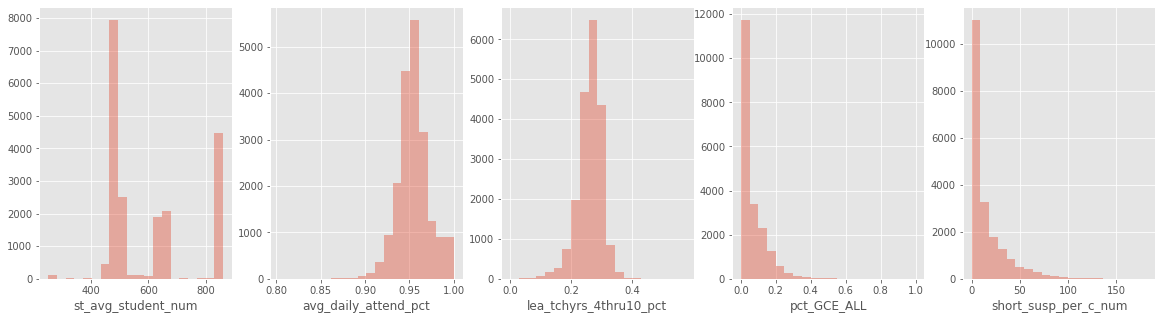

In [59]:
f, ax = plt.subplots(1,5,figsize=(20, 5))
sns.distplot(schoolData_X["st_avg_student_num"], bins=20, kde=False, ax=ax[0])
sns.distplot(schoolData_X["avg_daily_attend_pct"], bins=20, kde=False, ax=ax[1])
sns.distplot(schoolData_X["lea_tchyrs_4thru10_pct"], bins=20, kde=False, ax=ax[2])
sns.distplot(schoolData_X["pct_GCE_ALL"], bins=20, kde=False, ax=ax[3])
sns.distplot(schoolData_X["short_susp_per_c_num"], bins=20, kde=False, ax=ax[4])
plt.show()

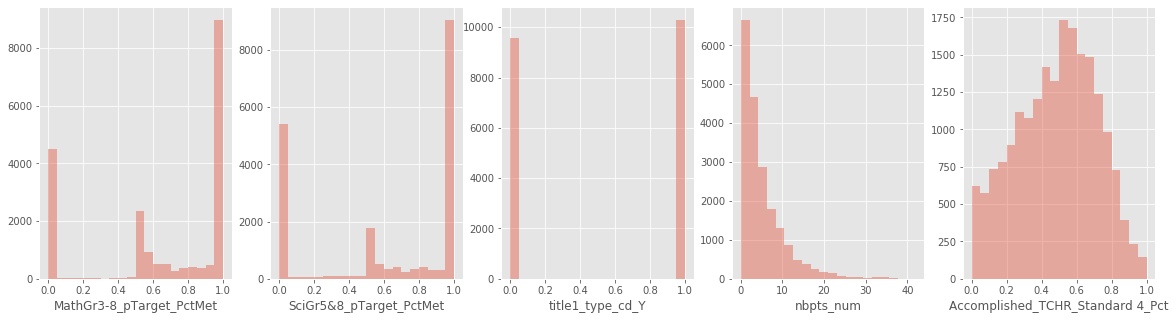

In [62]:
f, ax = plt.subplots(1,5,figsize=(20, 5))
sns.distplot(schoolData_X["MathGr3-8_pTarget_PctMet"], bins=20, kde=False, ax=ax[0])
sns.distplot(schoolData_X["SciGr5&8_pTarget_PctMet"], bins=20, kde=False, ax=ax[1])
sns.distplot(schoolData_X["title1_type_cd_Y"], bins=20, kde=False, ax=ax[2])
sns.distplot(schoolData_X["nbpts_num"], bins=20, kde=False, ax=ax[3])
sns.distplot(schoolData_X["Accomplished_TCHR_Standard 4_Pct"], bins=20, kde=False, ax=ax[4])
plt.show()

In [238]:
schoolData_org['category_cd'] == 'E'
# schools2['category_cd'].unique()
schoolData_org['category_cd_modified'] = np.select(
    [
        schoolData_org['category_cd'] == 'A', 
        schoolData_org['category_cd'] == 'E',
        schoolData_org['category_cd'] == 'H',
        schoolData_org['category_cd'] == 'I',
        schoolData_org['category_cd'] == 'M'
    ], 
    [
        'Elem./Mid./High Together', 
        'Elementary School',
        'High School',
        'Elem./Mid. Together',
        'Middle School'
    ],
    default='Mid./High Together'
)

pd.DataFrame(schoolData_org.category_cd_modified.value_counts())

0       False
1        True
2        True
3       False
4        True
        ...  
9726     True
9727    False
9728     True
9729    False
9730     True
Name: category_cd, Length: 9731, dtype: bool

,category_cd_modified
Elementary School,5160
High School,1965
Middle School,1892
Elem./Mid. Together,331
Mid./High Together,238
Elem./Mid./High Together,145


In [240]:
combo = schoolData_org['category_cd_modified'].str.contains('/', regex=False)

schoolData_org['category_cd_modified'] = np.where(combo, 'Combo', schoolData_org['category_cd_modified'])

pd.DataFrame(schoolData_org.category_cd_modified.value_counts())

,category_cd_modified
Elementary School,5160
High School,1965
Middle School,1892
Combo,714


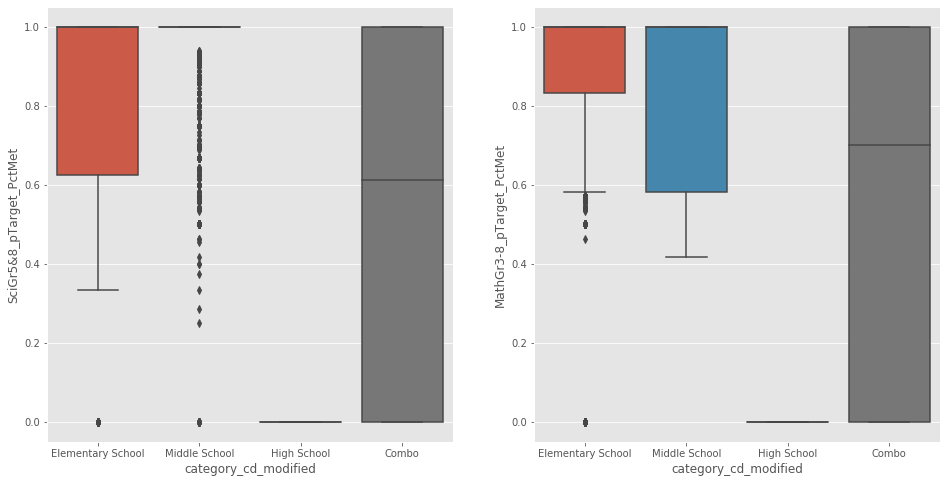

In [242]:
fig, axarr  = plt.subplots(1,2,figsize=(16,8))

#Science grade 
sns.boxplot(  y="SciGr5&8_pTarget_PctMet", x= "category_cd_modified", data=schoolData_org,
                orient='v' , ax=axarr[0],order=['Elementary School','Middle School','High School','Combo'])

#Math grade 
sns.boxplot(  y="MathGr3-8_pTarget_PctMet", x= "category_cd_modified", data=schoolData_org,
                orient='v' , ax=axarr[1],order=['Elementary School','Middle School','High School','Combo'])

We should exclude the variables "MathGr3-8_pTarget_PctMet","SciGr5&8_pTarget_PctMet".

In [153]:
schoolData_X_sub = schoolData_X[['short_susp_per_c_num','avg_daily_attend_pct','BlackMalePct','HispanicMalePct','pct_GCE_ALL','lea_flicensed_teach_pct','TotalTargets_pTarget_PctMet','nbpts_num' ]]
X = schoolData_X_sub

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  76.5164701977802 +- 0.7558656242882963


## Data Understanding - visualizing the data <a name="data-understanding-2"></a>

In [157]:
plot_train=X.sample(frac=0.98,random_state=200) #random state is a seed value
plot_test=X.drop(plot_train.index)
plot_testY=y.drop(plot_train.index)
plot_testY.columns = ['SPG']

frames = [plot_test, plot_testY]
plot_comb = pd.concat(frames,axis=1)

(Text(0.5, 0, 'Short Susp'), Text(0, 0.5, 'SPG'))

Text(0.5, 1.0, 'SPG Versus Short Susp')

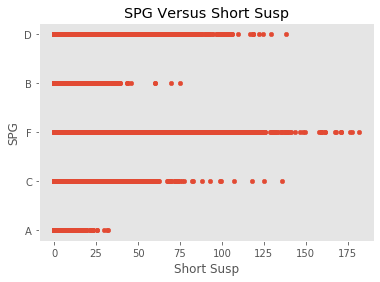

In [43]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline

plt.scatter(X.short_susp_per_c_num.values, y.values.flatten(), 
             s=20)
plt.xlabel('Short Susp'), plt.ylabel('SPG')
plt.grid()
plt.title('SPG Versus Short Susp')
plt.show()

(Text(0.5, 0, 'Avg attend'), Text(0, 0.5, 'SPG'))

Text(0.5, 1.0, 'SPG Versus Avg attend')

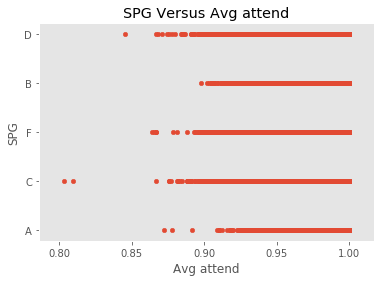

In [45]:
plt.scatter(X.avg_daily_attend_pct.values, y.values.flatten(), 
             s=20)
plt.xlabel('Avg attend'), plt.ylabel('SPG')
plt.grid()
plt.title('SPG Versus Avg attend')
plt.show()

(Text(0.5, 0, 'Black Male Pct'), Text(0, 0.5, 'SPG'))

Text(0.5, 1.0, 'SPG Versus Black Male Pct')

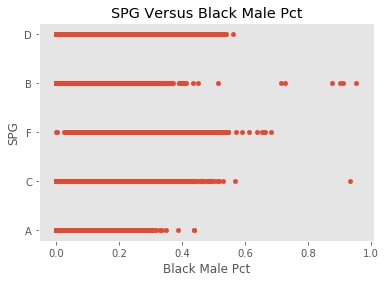

In [46]:
plt.scatter(X.BlackMalePct.values, y.values.flatten(), 
             s=20)
plt.xlabel('Black Male Pct'), plt.ylabel('SPG')
plt.grid()
plt.title('SPG Versus Black Male Pct')
plt.show()

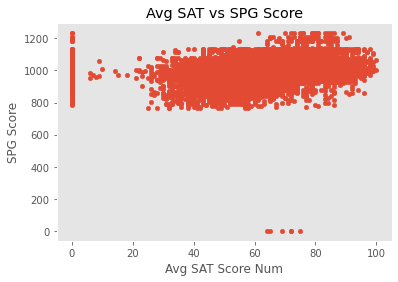

In [21]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = schoolData[['lea_sat_avg_score_num','SPG Score']].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('Avg SAT Score Num'), plt.ylabel('SPG Score')
plt.grid()
plt.title('Avg SAT vs SPG Score')
plt.show()

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'avg_daily_attend_pct'), Text(0, 0.5, 'short_susp_per_c_num'))

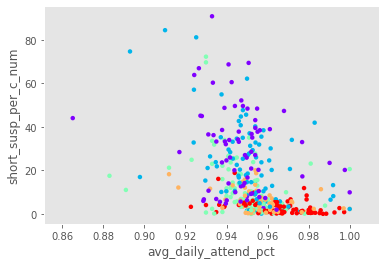

In [54]:
yy_fact = pd.factorize(plot_testY.T.squeeze())[0]
X1 = plot_test[['short_susp_per_c_num','avg_daily_attend_pct']]
X1=X1.values
plt.figure()
plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 0].shape)/2, c=yy_fact, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('avg_daily_attend_pct'), plt.ylabel('short_susp_per_c_num')
plt.grid()

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'BlackMalePct'), Text(0, 0.5, 'avg_daily_attend_pct'))

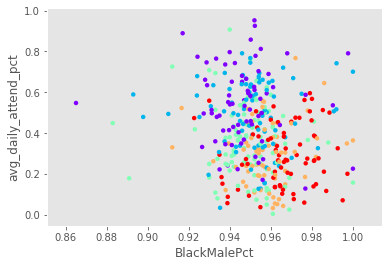

In [55]:
X1 = plot_test[['BlackMalePct','avg_daily_attend_pct']]
X1=X1.values
plt.figure()
plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 0].shape)/2, c=yy_fact, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('BlackMalePct'), plt.ylabel('avg_daily_attend_pct')
plt.grid()

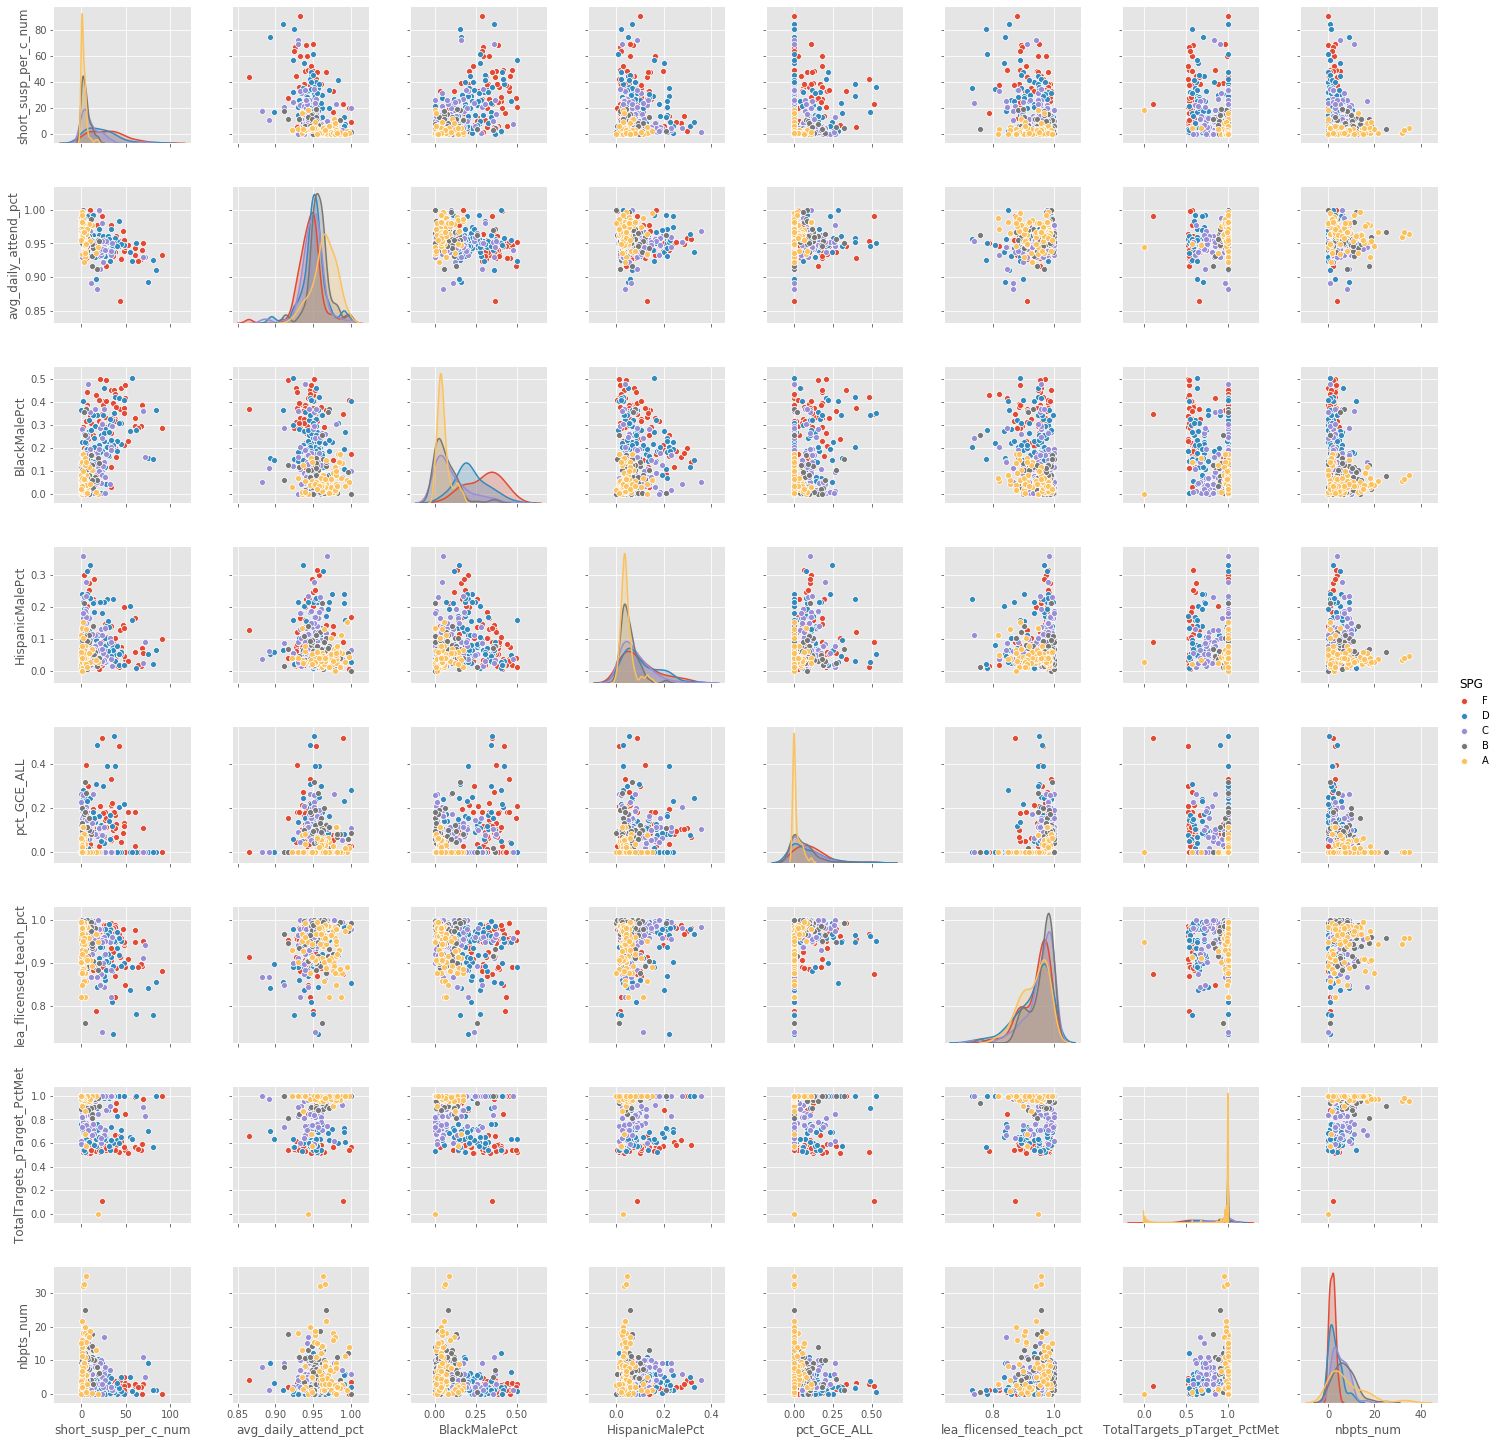

In [158]:
sns.pairplot(plot_comb, hue = "SPG")

## Models and Evaluations - Clustering <a name="model-evaluation"></a>

### KMeans

In [103]:
X.shape

(19865, 16)

In [102]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

#Xorg = schoolData_X[['short_susp_per_c_num','avg_daily_attend_pct','BlackMalePct','HispanicMalePct','pct_GCE_ALL','lea_flicensed_teach_pct','TotalTargets_pTarget_PctMet','nbpts_num' ]]
#X=Xorg

cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X)
newfeature = cls.labels_ # the labels from kmeans clustering

X = np.column_stack((X,pd.get_dummies(newfeature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with kmeans for class/fare)= ", acc.mean()*100, "+-", acc.std()*100)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

Average accuracy (with kmeans for class/fare)=  76.22952196876604 +- 0.8785350553659526


In [243]:
%%time 

X=Xorg

params = []
for n_fare in range(4,10):
        X=Xorg
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        X = np.column_stack((X,pd.get_dummies(newfeature_fare)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,acc.mean()*100,acc.std()*100)) # save state

        print ("Clusters",n_fare,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters 4 Average accuracy =  76.28993504326745 +- 0.9466100470201975
Clusters 5 Average accuracy =  76.39566305544535 +- 0.8332050862989009
Clusters 6 Average accuracy =  76.45102643838167 +- 0.8467448998191849
Clusters 7 Average accuracy =  76.34028142610771 +- 0.6021850665720532
Clusters 8 Average accuracy =  76.22952196876604 +- 0.8785350553659526
Clusters 9 Average accuracy =  76.22449736600272 +- 0.7998460462386866
Wall time: 2min 10s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'short_susp_per_c_num'), Text(0, 0.5, 'avg_daily_attend_pct'))

(Text(0.5, 0, 'short_susp_per_c_num'), Text(0, 0.5, 'BlackMalePct'))

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'avg_daily_attend_pct'), Text(0, 0.5, 'BlackMalePct'))

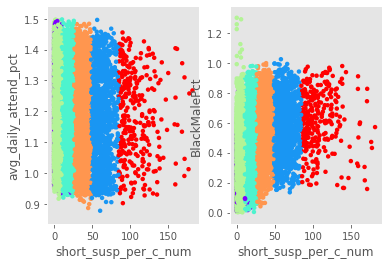

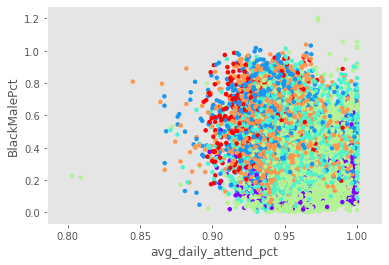

In [244]:
n_fare=6

cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
cls_fare.fit(X)
newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

plt.figure()
plt.subplot(1,2,1)
plt.scatter(X[:, 0], X[:, 1]+np.random.random(X[:, 1].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('short_susp_per_c_num'), plt.ylabel('avg_daily_attend_pct')
plt.grid()

plt.subplot(1,2,2)
plt.scatter(X[:, 0], X[:, 2]+np.random.random(X[:, 2].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('short_susp_per_c_num'), plt.ylabel('BlackMalePct')
plt.grid()

plt.figure()
plt.scatter(X[:, 1], X[:, 2]+np.random.random(X[:, 2].shape)/2, c=newfeature_fare, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('avg_daily_attend_pct'), plt.ylabel('BlackMalePct')
plt.grid()

In [250]:
%%time 

X1 = schoolData_X[['short_susp_per_c_num','avg_daily_attend_pct']]
X2 = schoolData_X[['pct_GCE_ALL','lea_flicensed_teach_pct','BlackMalePct']]

params = []
for n_fare in range(2,8):
    for n_fam in range(8,14,2):
        X=Xorg
        # get the first clustering
        cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
        cls_fare.fit(X1)
        newfeature_fare = cls_fare.labels_ # the labels from kmeans clustering

        # append on the second clustering
        cls_fam = KMeans(n_clusters=n_fam, init='k-means++',random_state=1)
        cls_fam.fit(X2)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        X = np.column_stack((X,pd.get_dummies(newfeature_fare),pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print ("Clusters",n_fare,n_fam,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters 2 8 Average accuracy =  75.96273069134261 +- 0.9820058577283621
Clusters 2 10 Average accuracy =  76.12382132619011 +- 0.7854171755850958
Clusters 2 12 Average accuracy =  76.28993580353418 +- 0.8329662717061889
Clusters 3 8 Average accuracy =  76.13890121661377 +- 1.0153280521017085
Clusters 3 10 Average accuracy =  76.05333091629338 +- 1.0629452835685587
Clusters 3 12 Average accuracy =  76.19429044861864 +- 0.7915337200781525
Clusters 4 8 Average accuracy =  76.20939314704395 +- 0.7361784257338517
Clusters 4 10 Average accuracy =  76.50638982131802 +- 0.9069373148308243
Clusters 4 12 Average accuracy =  76.47118110917228 +- 0.7090356307902533
Clusters 5 8 Average accuracy =  76.03824114240231 +- 0.8544100318807449
Clusters 5 10 Average accuracy =  76.19430185261947 +- 0.5356687380781241
Clusters 5 12 Average accuracy =  76.29497637189863 +- 0.7093795972179253
Clusters 6 8 Average accuracy =  75.99294369086046 +- 0.7986123203949674
Clusters 6 10 Average accuracy =  76.229551

### Agglomerative Clustering

In [246]:
%%time 

from sklearn.cluster import AgglomerativeClustering

X = Xorg

params = []
for link in ['ward', 'complete', 'average']:
    for n_fam in range(3,8):
        X=Xorg
        # append on the clustering
        cls_fam = AgglomerativeClustering(n_clusters=n_fam, linkage=link)
        cls_fam.fit(X)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print ("C=",n_fam,link,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

C= 3 ward Average accuracy =  76.52654221130844 +- 0.9340024219810111
C= 4 ward Average accuracy =  76.4057282265731 +- 0.8452708392855292
C= 5 ward Average accuracy =  76.40069906220947 +- 0.6828550475307295
C= 6 ward Average accuracy =  76.56178285465649 +- 0.6300230258897825
C= 7 ward Average accuracy =  76.23457470139803 +- 0.8229856104786428
C= 3 complete Average accuracy =  76.57686958748063 +- 1.0096105801668542
C= 4 complete Average accuracy =  76.60706434059718 +- 1.0490414576348104
C= 5 complete Average accuracy =  76.47619202713459 +- 1.141671916304717
C= 6 complete Average accuracy =  76.65238688094084 +- 0.8711891020158551
C= 7 complete Average accuracy =  76.51143571154951 +- 0.596131673094658
C= 3 average Average accuracy =  76.62720380605333 +- 0.8947394050570273
C= 4 average Average accuracy =  76.35536815893187 +- 1.1508733240465652
C= 5 average Average accuracy =  76.49632693099043 +- 1.1456810964199153
C= 6 average Average accuracy =  76.44095062351983 +- 1.07485348

### DBSCAN

In [247]:
%%time 

X = Xorg

from sklearn.cluster import DBSCAN

params = []
for eps in [0.1, 0.125, 0.15]:
    for mpts in range(5,8):
        X = Xorg
        # append on the clustering
        cls_fam = DBSCAN(eps=eps, min_samples=mpts)
        cls_fam.fit(X)
        newfeature_fam = cls_fam.labels_ # the labels from kmeans clustering

        X = np.column_stack((X,pd.get_dummies(newfeature_fam)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_fare,n_fam,acc.mean()*100,acc.std()*100)) # save state

        print (eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

0.1 5 Average accuracy =  76.36543485059306 +- 1.073084612350608
0.1 6 Average accuracy =  76.40067093234077 +- 1.0782363140170594
0.1 7 Average accuracy =  76.5567377246917 +- 1.003496610200417
0.125 5 Average accuracy =  76.13890805901427 +- 0.8231233048000587
0.125 6 Average accuracy =  76.03320969723852 +- 1.073892903871635
0.125 7 Average accuracy =  76.0784942242461 +- 0.8898680571642132
0.15 5 Average accuracy =  75.74124142706138 +- 0.5977461723418712
0.15 6 Average accuracy =  75.95768784217799 +- 0.8022711439503964
0.15 7 Average accuracy =  76.06338088208669 +- 1.0311973143329831
Wall time: 4min 1s


### Gaussian Mixture

In [80]:
X = schoolData_X[['short_susp_per_c_num','avg_daily_attend_pct','BlackMalePct','HispanicMalePct','pct_GCE_ALL','lea_flicensed_teach_pct','TotalTargets_pTarget_PctMet','nbpts_num' ]]
#X = Xorg

In [249]:
# this code has been manipulated from the source available on sklearn's website documentation
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

X = Xorg


lowest_bic = np.infty
bic = []
n_components_range = range(3, 8)
cv_types = ['spherical', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm


GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

<Figure size 720x288 with 0 Axes>

([<matplotlib.axis.XTick at 0x20279969a08>,
 <a list of 5 Text xticklabel objects>)

(-240223.88799982623, 805681.5172382661)

Text(0.5, 1.0, 'BIC score per model')

Text(6.8, -198801.89175277308, '*')

Text(0.5, 0, 'Number of components')

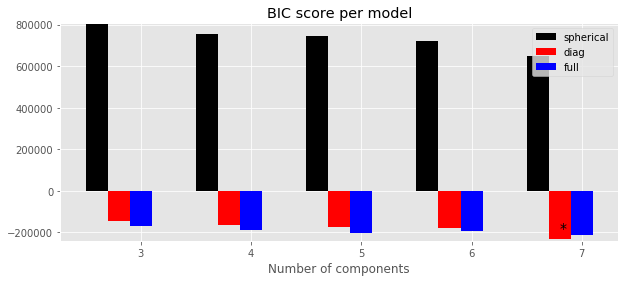

In [252]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

In [253]:
best_gmm

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [254]:
X = Xorg
cls_fam = best_gmm
Y_ = cls_fam.predict(X)
Y_
X = np.column_stack((X,pd.get_dummies(Y_)))

clf = RandomForestClassifier(n_estimators=150,random_state=1)
acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

array([1, 6, 3, ..., 3, 3, 0], dtype=int64)

Average accuracy =  75.4240954038638 +- 0.7322646883416103


### Spectral Clustering

In [122]:
# an example using SpectralClustering, which assumes that the graphical data needs to be calculated from the structure
from sklearn.cluster import SpectralClustering

X = Xorg

nclust = 10

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = SpectralClustering(n_clusters=nclust, affinity = 'nearest_neighbors')
labels = spc.fit_predict(X)


In [130]:
X = Xorg
clf = RandomForestClassifier(n_estimators=150,random_state=1)

params = []
#aff = ['nearest_neighbors', 'rbf']
aff = ['nearest_neighbors']
for nclust in range(6,12):
    for aff_type in aff:
        
        X = Xorg
        # append on the clustering
        spc = SpectralClustering(n_clusters=nclust, affinity = aff_type)
        labels = spc.fit_predict(X)

        X = np.column_stack((X,pd.get_dummies(labels)))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((nclust,acc.mean()*100,acc.std()*100)) # save state

        print (nclust,aff_type,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

6 nearest_neighbors Average accuracy =  76.37551522705525 +- 0.6251372432704223
7 nearest_neighbors Average accuracy =  76.3201442414517 +- 0.8238383357003491
8 nearest_neighbors Average accuracy =  76.10871558669791 +- 0.9244948085486766
9 nearest_neighbors Average accuracy =  76.3956501309111 +- 0.7774299084994601
10 nearest_neighbors Average accuracy =  76.26478770091587 +- 1.0603990711058788
11 nearest_neighbors Average accuracy =  76.27484222830952 +- 0.6019161678191045


### Model Evaluation and Comparison

In [256]:
X = Xorg

##Best Kmeans Model
n_fare=6

cls_fare = KMeans(n_clusters=n_fare, init='k-means++',random_state=1)
cls_fare.fit(X)
kmeans_fare = cls_fare.labels_ # the labels from kmeans clustering

##Best Agglomerative Clustering Model
cls_fam = AgglomerativeClustering(n_clusters=6, linkage='complete')
cls_fam.fit(X)
agg_fam = cls_fam.labels_ 

##Best DBSCAN Model
cls_fam = DBSCAN(eps=0.1, min_samples=7)
cls_fam.fit(X)
dbscan_fam = cls_fam.labels_ 

##Best Gaussian Mixture Model
cls_fam = best_gmm
GM_labels = cls_fam.predict(X)

##Best Spectral Clustering Model
spc = SpectralClustering(n_clusters=9, affinity = 'nearest_neighbors')
labels = spc.fit_predict(X)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=6)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=7, n_jobs=None, p=None)

In [257]:
#lab_option = ['kmeans_fare','agg_fam','dbscan_fam','GM_labels','labels']
lab_option = [kmeans_fare,agg_fam,dbscan_fam,GM_labels,labels]

for lab in lab_option:
    X = Xorg
    X = np.column_stack((X,pd.get_dummies(lab)))

    clf = RandomForestClassifier(n_estimators=150,random_state=1)
    acc = cross_val_score(clf,X,y=y,cv=cv)

    print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)


Average accuracy =  76.45102643838167 +- 0.8467448998191849
Average accuracy =  76.65238688094084 +- 0.8711891020158551
Average accuracy =  76.5567377246917 +- 1.003496610200417
Average accuracy =  75.4240954038638 +- 0.7322646883416103
Average accuracy =  76.12383273019093 +- 0.8888747660028815


### Clustering Visualization

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'avg_daily_attend_pct'), Text(0, 0.5, 'short_susp_per_c_num'))

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'avg_daily_attend_pct'), Text(0, 0.5, 'short_susp_per_c_num'))

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'avg_daily_attend_pct'), Text(0, 0.5, 'short_susp_per_c_num'))

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'avg_daily_attend_pct'), Text(0, 0.5, 'short_susp_per_c_num'))

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'avg_daily_attend_pct'), Text(0, 0.5, 'short_susp_per_c_num'))

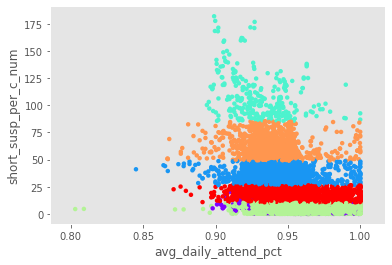

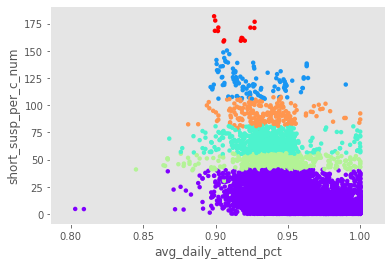

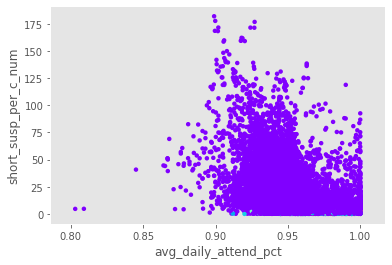

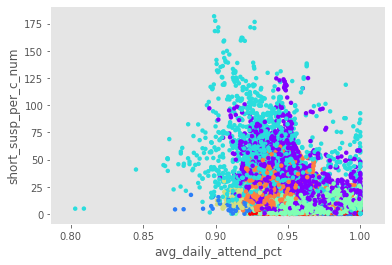

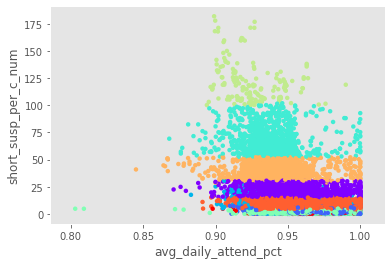

In [278]:
X=Xorg.values
lab_option = [kmeans_fare,agg_fam,dbscan_fam,GM_labels,labels]

for lab in lab_option:
 
    plt.figure()
    plt.scatter(X[:, 1], X[:, 0]+np.random.random(X[:, 0].shape)/2, c=lab, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('avg_daily_attend_pct'), plt.ylabel('short_susp_per_c_num')
    plt.grid()

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'PCA1'), Text(0, 0.5, 'PCA2'))

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'PCA1'), Text(0, 0.5, 'PCA2'))

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'PCA1'), Text(0, 0.5, 'PCA2'))

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'PCA1'), Text(0, 0.5, 'PCA2'))

<Figure size 432x288 with 0 Axes>

(Text(0.5, 0, 'PCA1'), Text(0, 0.5, 'PCA2'))

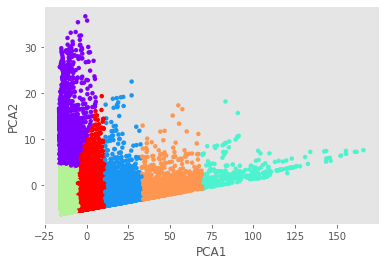

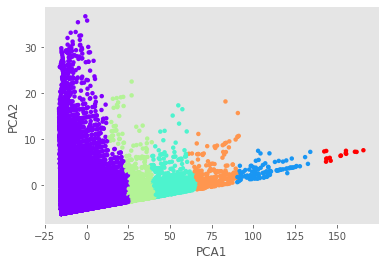

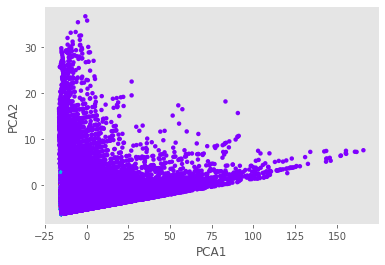

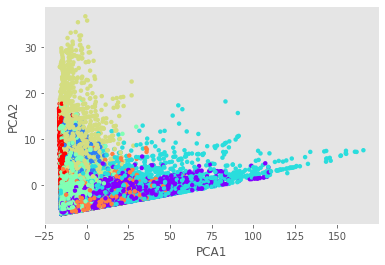

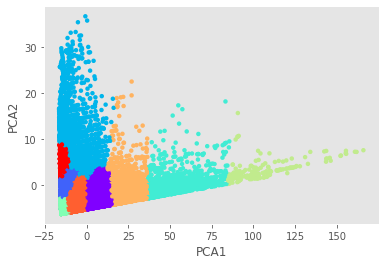

In [272]:
from sklearn.decomposition import PCA
PCA_subset = PCA(n_components=2)
PC_subset = PCA_subset.fit_transform(X)
PC_DFsubset = pd.DataFrame(data = PC_subset, columns = ['PCA1', 'PCA2'])

for lab in lab_option:
    
    plt.figure()
    plt.scatter(PC_DFsubset.PCA1, PC_DFsubset.PCA2, c=lab, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('PCA1'), plt.ylabel('PCA2')
    plt.grid()
    

In [261]:
## Try to combine multiple labels into the model
X = Xorg
lab_option = [agg_fam,dbscan_fam]

for lab in lab_option:
    X = np.column_stack((X,pd.get_dummies(lab)))

    clf = RandomForestClassifier(n_estimators=150,random_state=1)
    acc = cross_val_score(clf,X,y=y,cv=cv)

    print ("Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy =  76.65238688094084 +- 0.8711891020158551
Average accuracy =  76.23455569472998 +- 1.2052712955637872


### Classification Model Refitting

In [263]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 
#Training using Oversample Method
X = Xorg
Xlab = np.column_stack((X,pd.get_dummies(agg_fam)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xlab_train, Xlab_test, y_train, y_test = train_test_split(Xlab, y, test_size=0.2, random_state=42)

In [255]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

#Have to do random search since grid search takes forever
grid_rf = RandomizedSearchCV(RandomForestClassifier(), param_grid_rf, refit=True, verbose=2, n_jobs=-1)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 14.2min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [259]:
#Print the parameterization of the best estimator
grid_rf.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [280]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

rf_mod = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf_mod1 = rf_mod.fit(X_train, y_train)

pred_rf = rf_mod1.predict(X_test)

print(accuracy_score(y_test, pred_rf))
print(precision_score(y_test, pred_rf, average='weighted'))
print(recall_score(y_test, pred_rf, average='weighted'))
print(confusion_matrix(y_test, pred_rf))

0.8238107223760383
0.8206180971342719
0.8238107223760383
[[749  31   1   0   0]
 [ 54 630 122  13   1]
 [  6 131 507 114   8]
 [  2  11  90 660  77]
 [  0   0   2  37 727]]


In [285]:
#Have to do random search since grid search takes forever
grid_rflab = RandomizedSearchCV(RandomForestClassifier(), param_grid_rf, refit=True, verbose=2, n_jobs=-1)
grid_rflab.fit(Xlab_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 23.5min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [286]:
#Print the parameterization of the best estimator
grid_rflab.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [288]:
rf_mod2 = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

rf_mod2.fit(Xlab_train, y_train)

pred_rflab = rf_mod2.predict(Xlab_test)

print(accuracy_score(y_test, pred_rflab))
print(precision_score(y_test, pred_rflab, average='weighted'))
print(recall_score(y_test, pred_rflab, average='weighted'))
print(confusion_matrix(y_test, pred_rflab))

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

0.8255726151522779
0.8221638167746868
0.8255726151522779
[[752  29   0   0   0]
 [ 59 626 121  14   0]
 [  6 139 503 111   7]
 [  2  10  89 672  67]
 [  0   0   1  38 727]]


In [289]:
# Probability Matrix
yhat_score_rf = rf_mod1.predict_proba(X_test)
yhat_score_rf

# Probability Matrix
yhat_score_rflab = rf_mod2.predict_proba(Xlab_test)
yhat_score_rflab

array([[0.    , 0.    , 0.0875, 0.085 , 0.8275],
       [0.    , 0.    , 0.1625, 0.785 , 0.0525],
       [0.    , 0.    , 0.    , 0.01  , 0.99  ],
       ...,
       [0.0025, 0.015 , 0.1625, 0.7375, 0.0825],
       [0.    , 0.    , 0.0075, 0.0175, 0.975 ],
       [0.0025, 0.0575, 0.23  , 0.4125, 0.2975]])

array([[0.    , 0.    , 0.115 , 0.08  , 0.805 ],
       [0.    , 0.    , 0.1475, 0.8   , 0.0525],
       [0.    , 0.    , 0.    , 0.    , 1.    ],
       ...,
       [0.    , 0.0225, 0.165 , 0.715 , 0.0975],
       [0.    , 0.    , 0.005 , 0.005 , 0.99  ],
       [0.    , 0.04  , 0.2625, 0.3975, 0.3   ]])

In [183]:
from sklearn.preprocessing import label_binarize
one_hot_class_encoding = label_binarize(y_test,np.unique(y_test))
one_hot_class_encoding

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0]])

In [179]:
one_hot_class_encoding.shape

(19865, 5)

In [181]:
def PlotROC_All(y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr["micro"], tpr["micro"], _ = mt.roc_curve(one_hot_class_encoding.ravel(), y_score.ravel())
    roc_auc["micro"] = mt.auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(12,4))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    return roc_auc["micro"]

0.9711581522875687

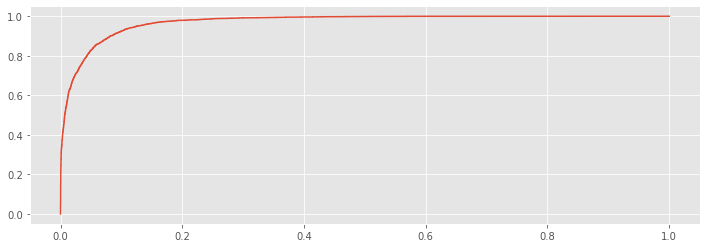

In [184]:
PlotROC_All(yhat_score_rf)

In [290]:
from sklearn import metrics as mt

#Separate ROC curves for different classifiers
fpr_rf, tpr_rf, _ = mt.roc_curve(one_hot_class_encoding.ravel(), yhat_score_rf.ravel())
roc_auc_rf = mt.auc(fpr_rf, tpr_rf)

#Separate ROC curves for different classifiers
fpr_rflab, tpr_rflab, _ = mt.roc_curve(one_hot_class_encoding.ravel(), yhat_score_rflab.ravel())
roc_auc_rflab = mt.auc(fpr_rflab, tpr_rflab)


<Figure size 1152x648 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic for cardio = 0')

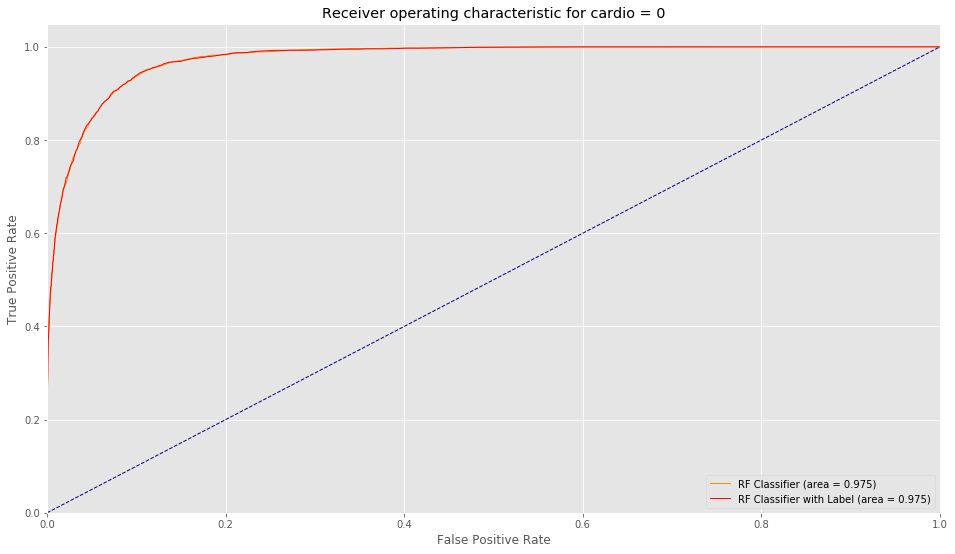

In [291]:
plt.figure(figsize=(16,9));
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=1, label='RF Classifier (area = %0.3f)' % roc_auc_rf)
plt.plot(fpr_rflab, tpr_rflab, color='red', lw=1, label='RF Classifier with Label (area = %0.3f)' % roc_auc_rflab)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for cardio = 0')
plt.legend(loc="lower right")
plt.show()

### Train and Parameter Tuning <a name="model-evaluation-1"></a>

### Evaluate and Compare <a name="model-evaluation-2"></a>

### Cluster Visualization <a name="model-evaluation-3"></a>

### Summary <a name="model-evaluation-4"></a>

## Deployment

## Exceptional Work